# Cross-modal comparison of high-level representations: an ecologically motivated approach to prompt engineering for zero-shot image classification within a multimodal network

### Shawn Manuel, Abbas Guennoun

_ _ _

In [64]:
import os
from PIL import Image
import numpy as np
from numpy import save, load
import IPython.display
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
import umap
# import umap.plot
import seaborn as sns
import torch
# import skimage
from pkg_resources import packaging
# import clip
import pandas as pd
import re
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Layout

import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Étape 1 : Préparer le dataframe contenant les variables psycholinguistiques, télécharger les images

In [4]:
### Load DIRTI supplementary data
df = pd.read_excel('/Users/shwnmnl/Documents/Stimuli/DIRTI/DIRTI_Supplementary.xlsx')
df['categorie'] = df.loc[:, 'name']

# Make last column first
def make_first(df):
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    return df

# Create new column containing only category name
df['categorie'].replace(to_replace=r'(\d*)_food', value='food', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_food neutral', value='food', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_animals', value='animals', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_animals neutral', value='animals', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_body products', value='body_products', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_body products neutral', value='body_products', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_injuries_infections', value='injuries_infections', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_injuries_infections neutral', value='injuries_infections', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_death', value='death', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_death neutral', value='death', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_hygiene', value='hygiene', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'(\d*)_hygiene neutral', value='hygiene', regex=True, inplace=True) 


In [5]:
### Drop 'neutral', didn't work as expected at last step
df['categorie'].replace(to_replace=r'food neutral', value='food', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'animals neutral', value='animals', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'body_products neutral', value='body_products', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'injuries_infections neutral', value='injuries_infections', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'death neutral', value='death', regex=True, inplace=True)
df['categorie'].replace(to_replace=r'hygiene neutral', value='hygiene', regex=True, inplace=True) 

df = make_first(df)
df

,categorie,name,disg_mean_all,disg_SD_all,disg_mean_women,disg_SD_women,disg_mean_men,disg_SD_men,sex_diff_disg,t_sex_diff_disg_df_198,p_sex_diff_disg,cohens_d_sex_diff_disg,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,food,1001_food,5.095,2.545264,5.392157,2.442028,4.785714,2.625215,0,1.692308,0.092160,0.239202,NaN,Variable,Description
1,food,1002_food,5.085,2.588683,5.519608,2.488510,4.632653,2.625756,1,2.452593,0.015049,0.346730,NaN,name,picture number / name
2,food,1003_food,5.205,2.578024,5.656863,2.483590,4.734694,2.602739,1,2.564015,0.011088,0.362507,NaN,disg_mean_all,mean disgust rating for the picture (all parti...
3,food,1004_food,4.120,2.421761,4.558824,2.479913,3.663265,2.283711,1,2.653725,0.008607,0.375680,NaN,disg_SD_all,standard deviation for the disgust rating for...
4,food,1005_food,5.145,2.584059,5.519608,2.508324,4.755102,2.616605,1,2.109645,0.036145,0.298281,NaN,disg_mean_women,mean disgust rating for the picture (women only)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,hygiene,1296_hygiene neutral,1.135,0.623473,1.117647,0.601880,1.153061,0.647788,0,-0.400719,0.689059,-0.056639,NaN,NaN,NaN
296,hygiene,1297_hygiene neutral,1.090,0.439163,1.039216,0.195066,1.142857,0.592043,0,-1.675987,0.095319,-0.235134,NaN,NaN,NaN
297,hygiene,1298_hygiene neutral,1.110,0.556280,1.127451,0.608058,1.091837,0.499210,0,0.451709,0.651973,0.064020,NaN,NaN,NaN
298,hygiene,1299_hygiene neutral,1.050,0.279087,1.019608,0.139333,1.081633,0.370941,0,-1.577033,0.116384,-0.221368,NaN,NaN,NaN


In [6]:
### Label enconding of categories
df['num_cat'] = df.categorie.map({'food':0, 'animals':1, 'body_products':2, 'injuries_infections':3, 'death':4, 'hygiene':5})
df = make_first(df)

In [7]:
disg_mean = df['disg_mean_all'].mean()
disg_std = df['disg_mean_all'].std()
print(f'Disg mean score: {disg_mean}, Standard Deviation: {disg_std}')

Disg mean score: 3.4594333333333322, Standard Deviation: 1.4924876583263293


In [8]:
### This part is label encoding rows where the average disgust score was >=5
### Indexes where found using:
### df.index[df['disg_mean_all'] >= 5].tolist()

df['disg_num_cat'] = df['num_cat']

# Food
for i in [0,1,2,4,6,8,10,12,14,22,25,28,31,33,37,39]:
    df['disg_num_cat'][i] = 6

# Body_Products
for i in [111,115,117,118,119,130,133,134,137,138,139]:
    df['disg_num_cat'][i] = 8

# Injuries
for i in [159,164,177]:
    df['disg_num_cat'][i] = 9

# Death
for i in [201,202,204,208,210,213,214,222,224,230,231,237,239]:
    df['disg_num_cat'][i] = 10

# Hygiene
for i in [257, 270, 275]:
    df['disg_num_cat'][i] = 11

/var/folders/fb/tx890psd65zdxmvrlxh9dzq40000gn/T/ipykernel_9682/52405704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disg_num_cat'] = df['num_cat']
/var/folders/fb/tx890psd65zdxmvrlxh9dzq40000gn/T/ipykernel_9682/52405704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disg_num_cat'][i] = 6
/var/folders/fb/tx890psd65zdxmvrlxh9dzq40000gn/T/ipykernel_9682/52405704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [57]:
### Loads images 
images = []
stim_names = []

for i in os.listdir('/Users/shwnmnl/Documents/Stimuli/DIRTI/DIRTI Database'):
    stim_names.append(i)
    
stim_names.sort()

for i in stim_names:
    try:
        images.append(Image.open('/Users/shwnmnl/Documents/Stimuli/DIRTI/DIRTI Database/'+i).convert("RGB"))
    except IsADirectoryError:
        continue

# Image viz widget
def browse_images(digits):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], interpolation='nearest')
        plt.title('DIRTI Image: %s' % i)
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(images)


interactive(children=(IntSlider(value=149, description='i', max=299), Output()), _dom_classes=('widget-interac…

## Étape 2 : Choix de modèle, preprocessing des images, extraction des caractéristiques et prédictions/performances

Cette section a été roulée spécifiquement sur la machine Alienware pour améliorer la vitesse de traitement

In [ ]:
### Model choice, image preprocessing, feature extraction and label prediction
### This step was completed on a separate machine with a more powerful GPU/CPU

# Check torch version
print("Torch version:", torch.__version__)

# Check list of CLIP models
clip.available_models()

# This is a model with the transformer
model, preprocess = clip.load("ViT-B/32")

# This is the ResNet 50 they used in the online microscope
# model, preprocess = clip.load("RN50x64")

# Check parameters
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

# Get images and their names
stim_names = []
original_images = []
images = []

for i in os.listdir('/home/eclips/Documents/DeepProjections/DIRTI'):
    stim_names.append(i)
stim_names.sort()
stim_names.pop(0)

for i in stim_names:
    original_images.append(Image.open('/home/eclips/Documents/DeepProjections/DIRTI/'+i).convert("RGB"))
    images.append(preprocess(Image.open('/home/eclips/Documents/DeepProjections/DIRTI/'+i).convert("RGB")))

# Make tensor out of images
image_input = torch.tensor(np.stack(images)).cuda()

# Extract image features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    
# Create image labels and descriptions to be tokenized
# There are two descriptions variants, one for basic zero-shot classification;
# and the other for the 'disgust' related part
categories = ['food', 'animals','body products','injuries/infections','death','hygiene']
adjectives = ['disgusting', '']
descriptions = [f"This is a photo of {label}" for label in categories]
disg_descriptions = [f"This is a {adj} photo of {label}" for adj in adjectives for label in categories]
text_tokens = clip.tokenize(descriptions).cuda()
disg_text_tokens = clip.tpkenize(disg_descriptions).cuda()

# Extract text features
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    disg_text_features = model.encode_text(disg_text_tokens).float()
    disg_text_features /= disg_text_features.norm(dim=-1, keepdim=True)

# Make top 5 label prediction for every image
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cuda().topk(5, dim=-1)

disg_text_probs = (100.0 * image_features @ disg_text_features.T).softmax(dim=-1)
disg_top_probs, disg_top_labels = disg_text_probs.cuda().topk(5, dim=-1)

# Print predictions and probabilities
print(top_probs)
print(top_labels)
print(disg_top_probs)
print(disg_top_labels)

# Save image features and top label predictions
np.save('image_features.npy', image_features)
np.save('basic_top_labels.npy', top_labels)
np.save('disg_top_labels.npy', disg_top_labels)


## Étape 3 : Visualisations des images DIRTI dans l'espace latent de CLIP

In [9]:
image_features = np.load('scaled_image_features.npy')
scaled_image_features = StandardScaler().fit_transform(image_features)

In [10]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_image_features)
embedding.shape

(300, 2)

In [49]:
mapper = umap.UMAP().fit(scaled_image_features)

<AxesSubplot:>

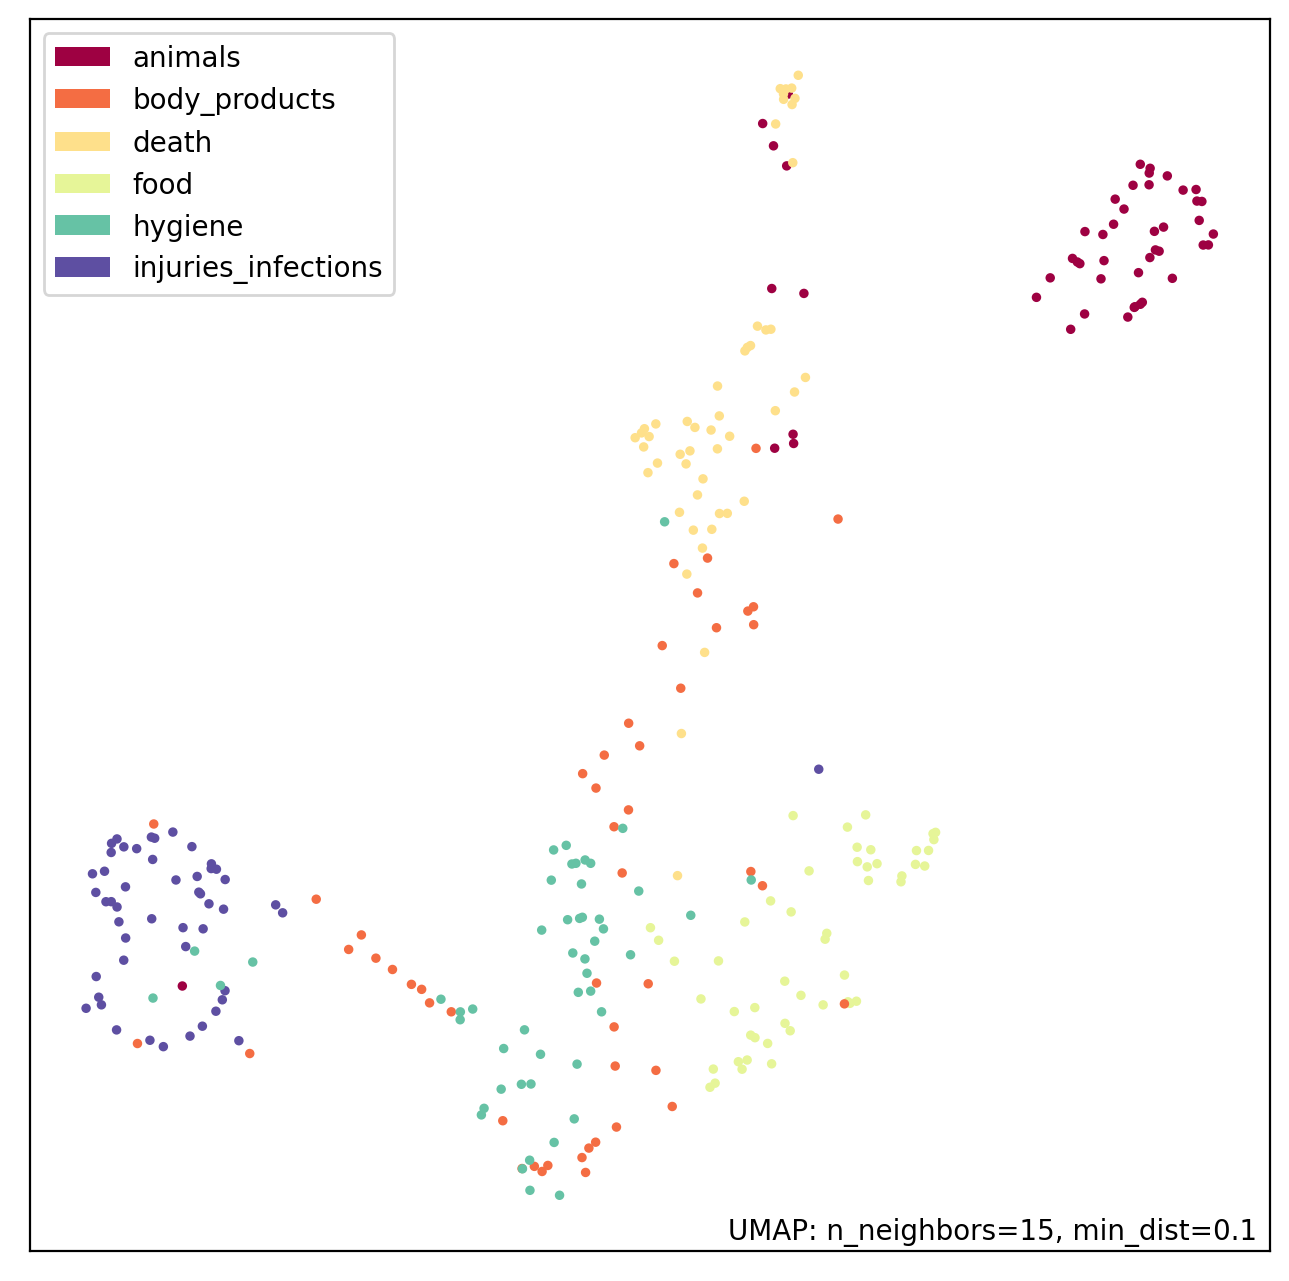

In [52]:
import umap.plot
hover_data = pd.DataFrame({'index':np.arange(300),
                           'label': df.categorie[:300]})
hover_data['item'] = hover_data.label.map(
    {
        '0':'food',
        '1':'animals',
        '2':'body_products',
        '3':'injuries_infections',
        '4':'death',
        '5':'hygiene'
    }
)
umap.plot.points(mapper, labels=df.categorie)

In [53]:
umap.plot.output_notebook()

Loading BokehJS ...

In [54]:
p = umap.plot.interactive(mapper, labels=df.categorie[:300], hover_data=hover_data, point_size=10)
umap.plot.show(p)


## Étape 4 : Performances prédictives de l'embedding de base + K plus-proches-voisins comme comparateur

### Performances prédictives CLIP

In [58]:
basic_top_labels = np.load('/Users/shwnmnl/Documents/Stimuli/DIRTI/basic_top_labels.npy')
disg_top_labels = np.load('/Users/shwnmnl/Documents/Stimuli/DIRTI/disg_top_labels.npy')

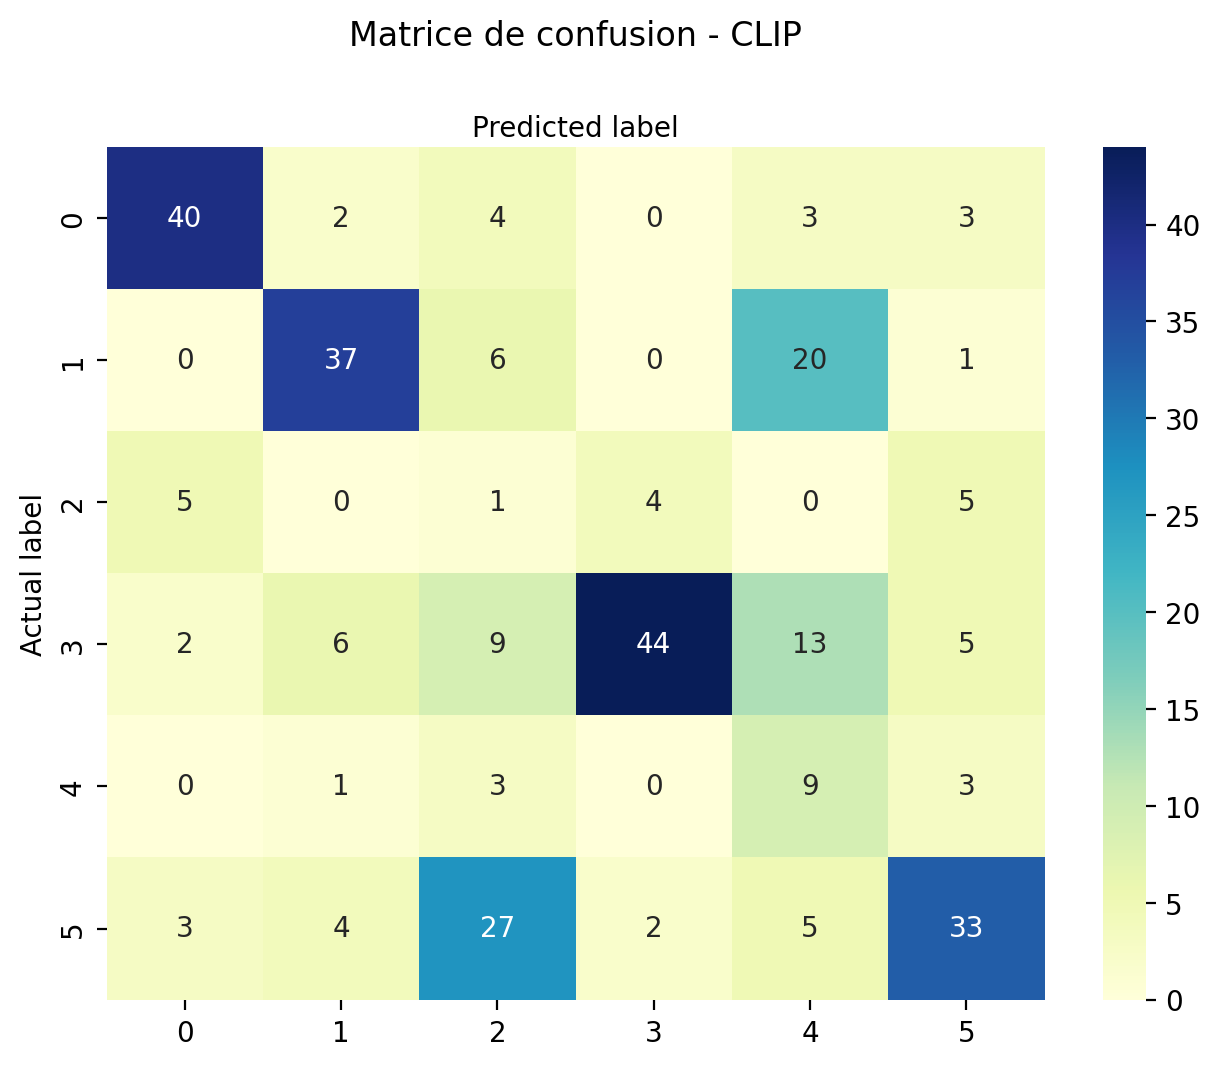

In [113]:
basic_cm = metrics.confusion_matrix(basic_top_labels[:,0], df['num_cat'])
class_names = ['food', 'animals', 'body_products', 'injuries_infections', 'death', 'hygiene']
fix, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(ticks=tick_marks, labels=class_names)
plt.yticks(ticks=tick_marks, labels=class_names)
sns.heatmap(pd.DataFrame(basic_cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrice de confusion - CLIP', y =1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [114]:
print(metrics.classification_report(basic_top_labels[:,0], df['num_cat']))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78        52
           1       0.74      0.58      0.65        64
           2       0.02      0.07      0.03        15
           3       0.88      0.56      0.68        79
           4       0.18      0.56      0.27        16
           5       0.66      0.45      0.53        74

    accuracy                           0.55       300
   macro avg       0.55      0.50      0.49       300
weighted avg       0.70      0.55      0.60       300



___
### Performances prédictives KNN

In [91]:
# Get the data and model ready
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
model = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
X_train, X_test, y_train, y_test = train_test_split(embedding, df['num_cat'], random_state=seed, test_size=0.3)
Z_train = StandardScaler().fit_transform(X_train)
Z_test = StandardScaler().fit_transform(X_test)

# Fit model, predict and print result
model.fit(Z_train,y_train)
y_pred = model.predict(Z_test)
print(f'Predictive performance: {metrics.classification_report(y_test,y_pred)}')

Predictive performance:               precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       1.00      0.74      0.85        19
           2       0.47      0.54      0.50        13
           3       0.93      0.93      0.93        15
           4       0.72      0.81      0.76        16
           5       0.42      0.45      0.43        11

    accuracy                           0.76        90
   macro avg       0.75      0.74      0.74        90
weighted avg       0.78      0.76      0.76        90



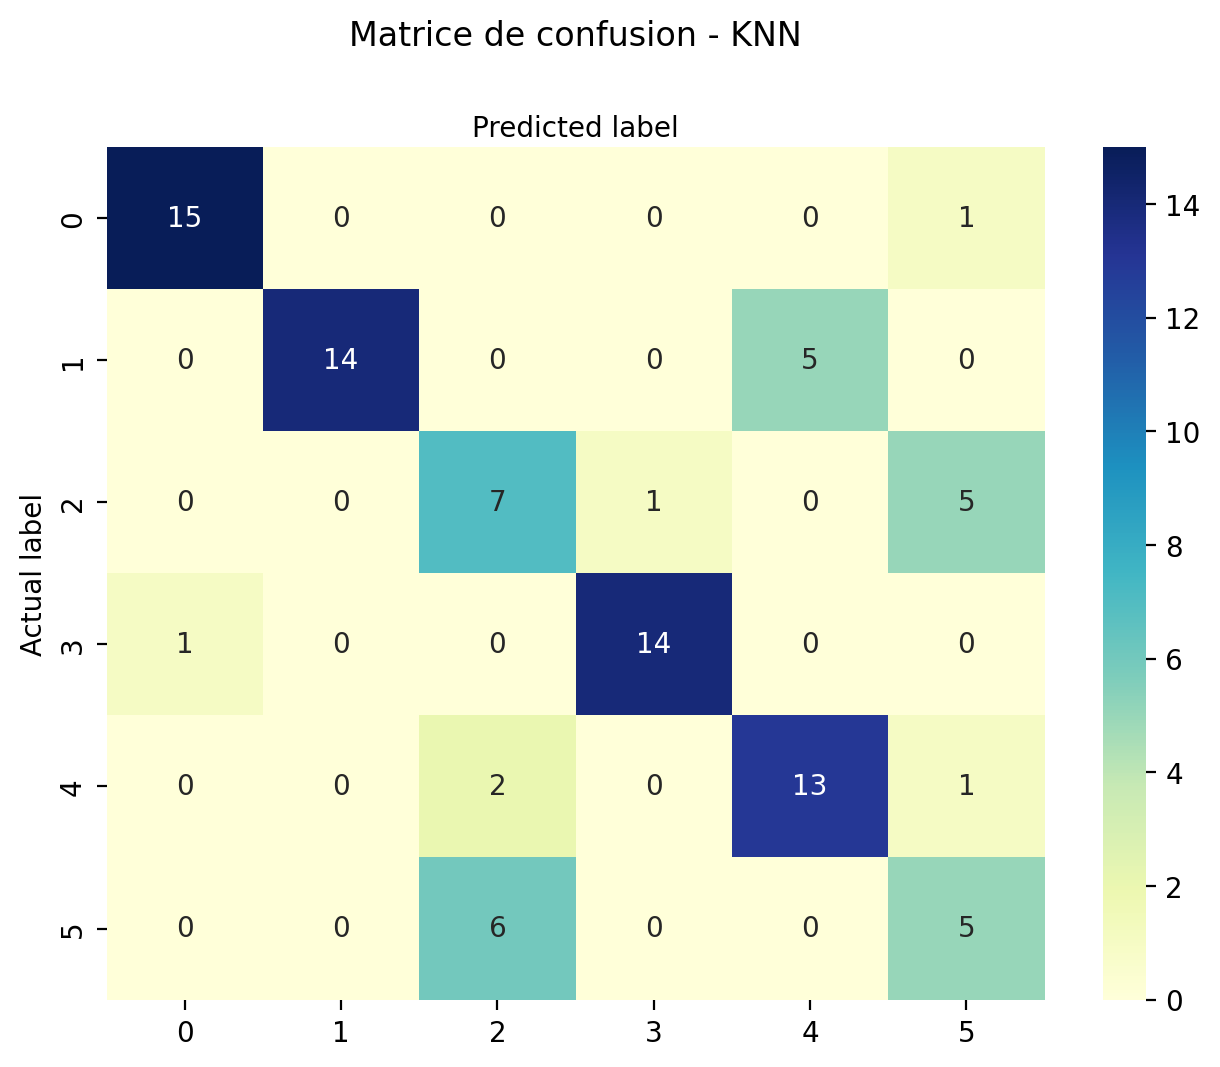

In [92]:
knn_cm = metrics.confusion_matrix(y_test,y_pred)
class_names = ['food', 'animals', 'body_products', 'injuries_infections', 'death', 'hygiene']
fix, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(ticks=tick_marks, labels=class_names)
plt.yticks(ticks=tick_marks, labels=class_names)
sns.heatmap(pd.DataFrame(knn_cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrice de confusion - KNN', y =1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

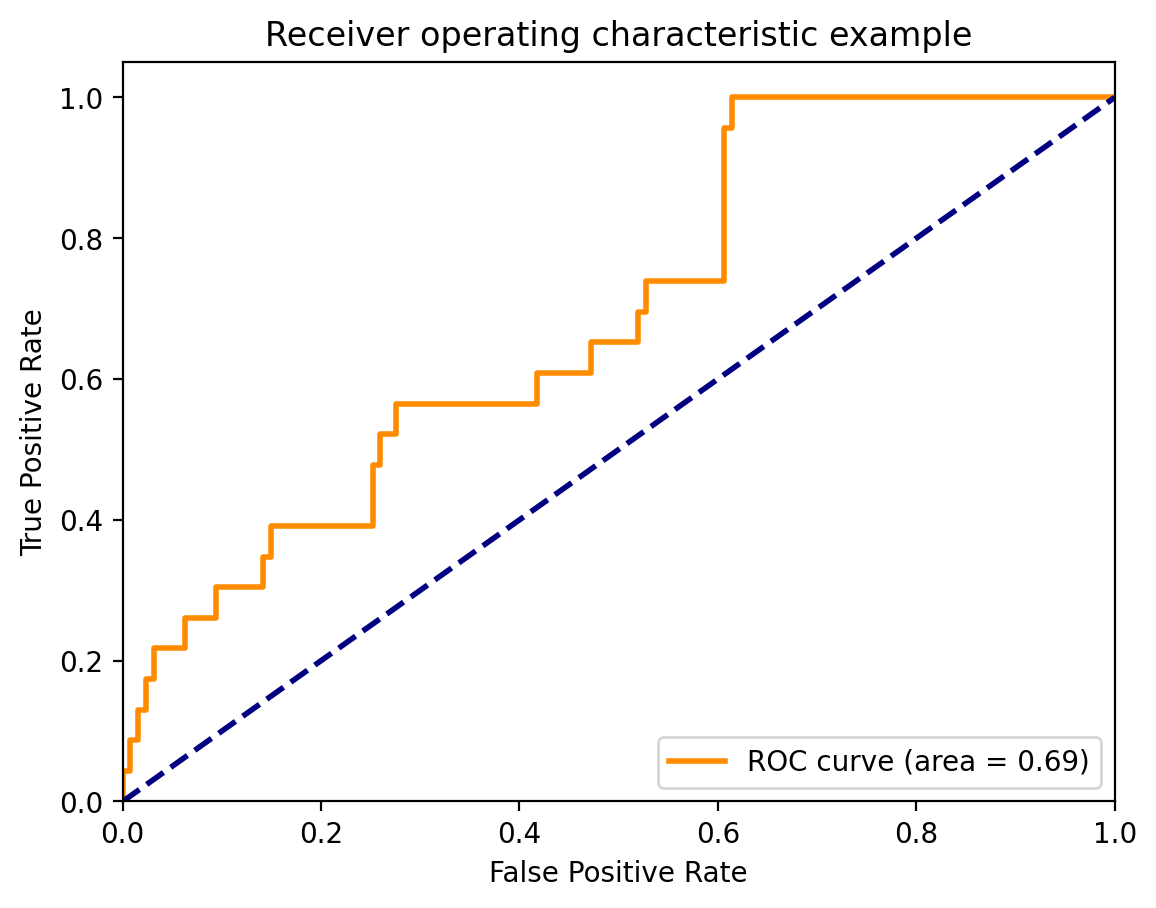

In [93]:
y = label_binarize(df['num_cat'], classes=[0,1,2,3,4,5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(embedding, y, random_state=0, test_size=0.5)

random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True, random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ")
plt.legend(loc="lower right")
plt.show()

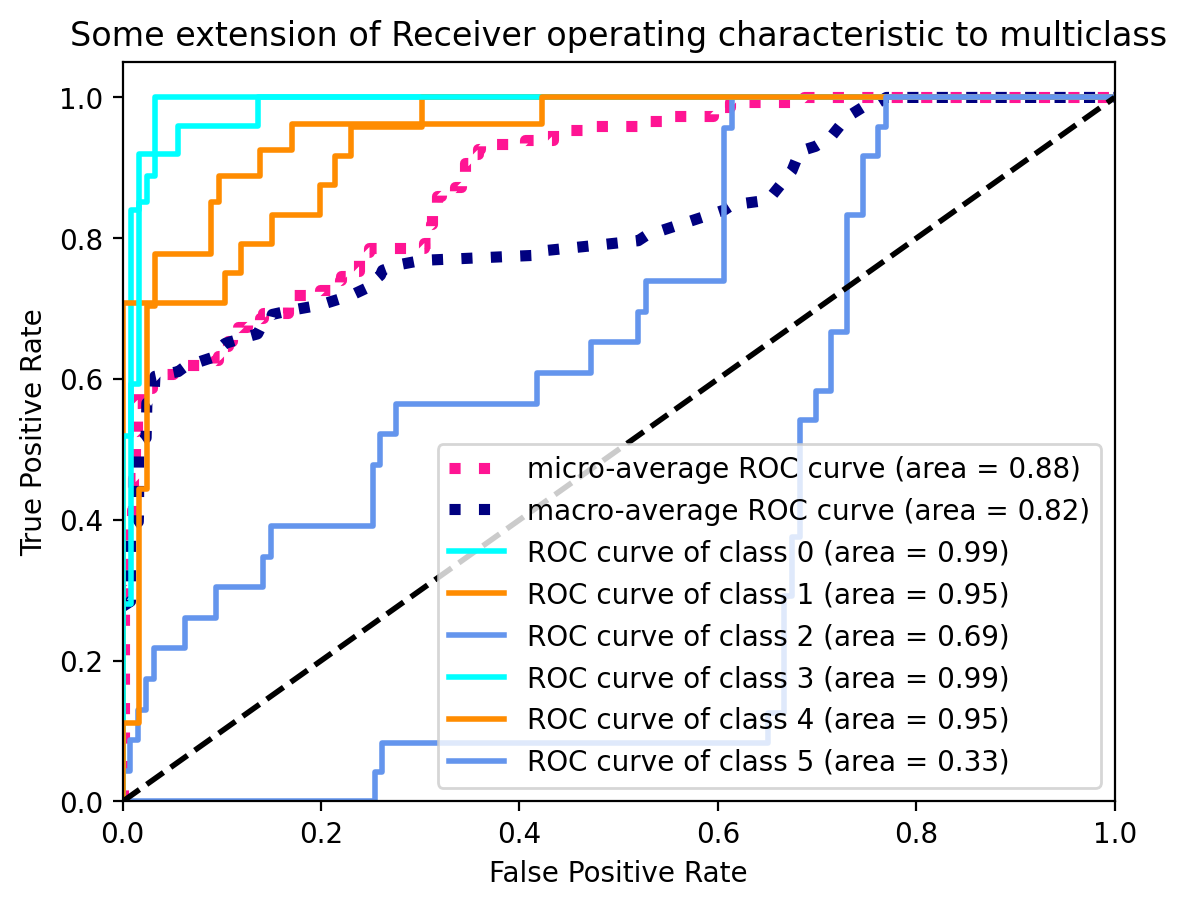

In [73]:
# Macro

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


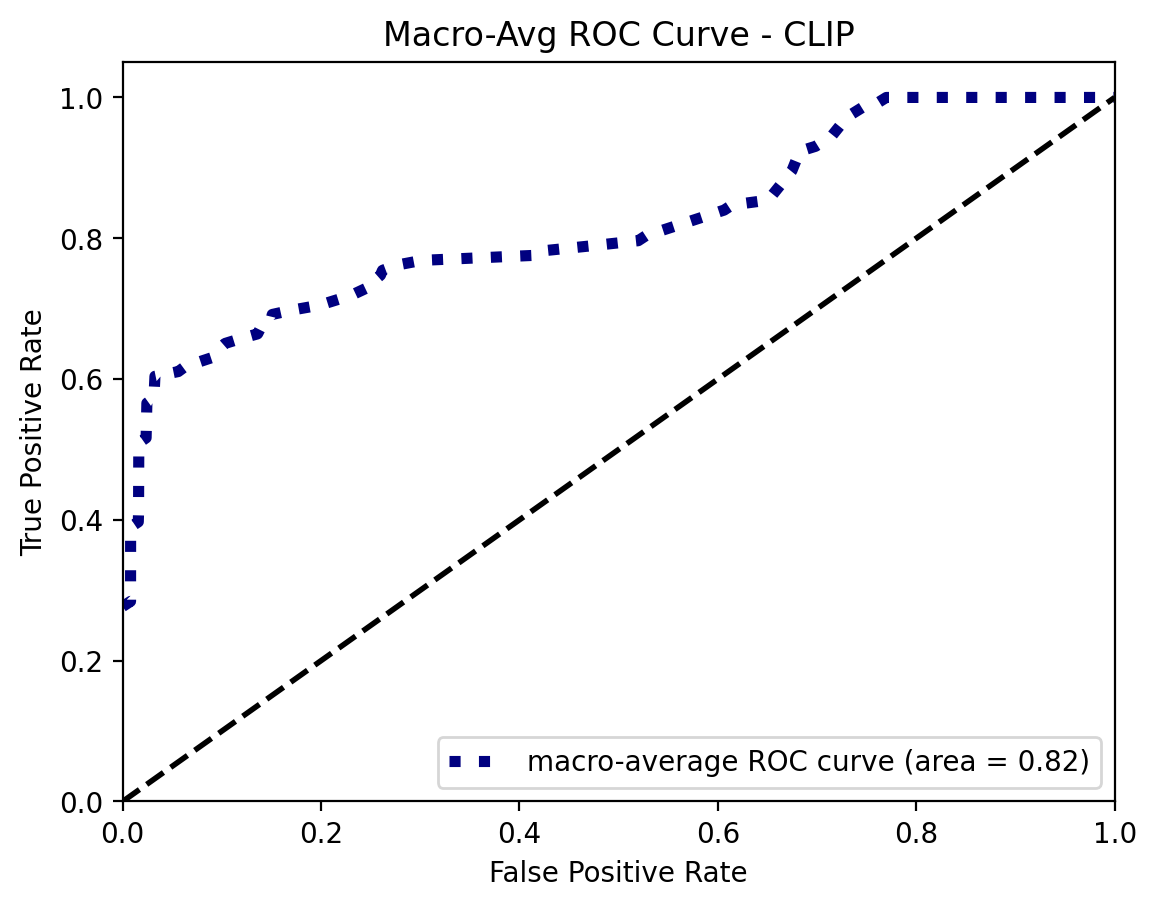

In [94]:
# Macro

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

# colors = cycle(["aqua", "darkorange", "cornflowerblue"])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(
#         fpr[i],
#         tpr[i],
#         color=color,
#         lw=lw,
#         label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
#     )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Avg ROC Curve - CLIP")
plt.legend(loc="lower right")
plt.show()


In [75]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.752615 (macro),
0.765798 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.752615 (macro),
0.765798 (weighted by prevalence)


## Étape 5 : Performances prédictives de l'embedding écologiquement motivée + K plus-proches-voisins comme comparateur

Cette section est quelque peu problématique, une erreur qui jusqu'à présent demeure inconnue, empêche d'avoir les prédictions pour toutes les classes. Deux sont manquantes. Nous y reviendrons et offrirons une update lorsque possible. 

In [108]:
set(df['disg_num_cat'].unique())

{0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11}

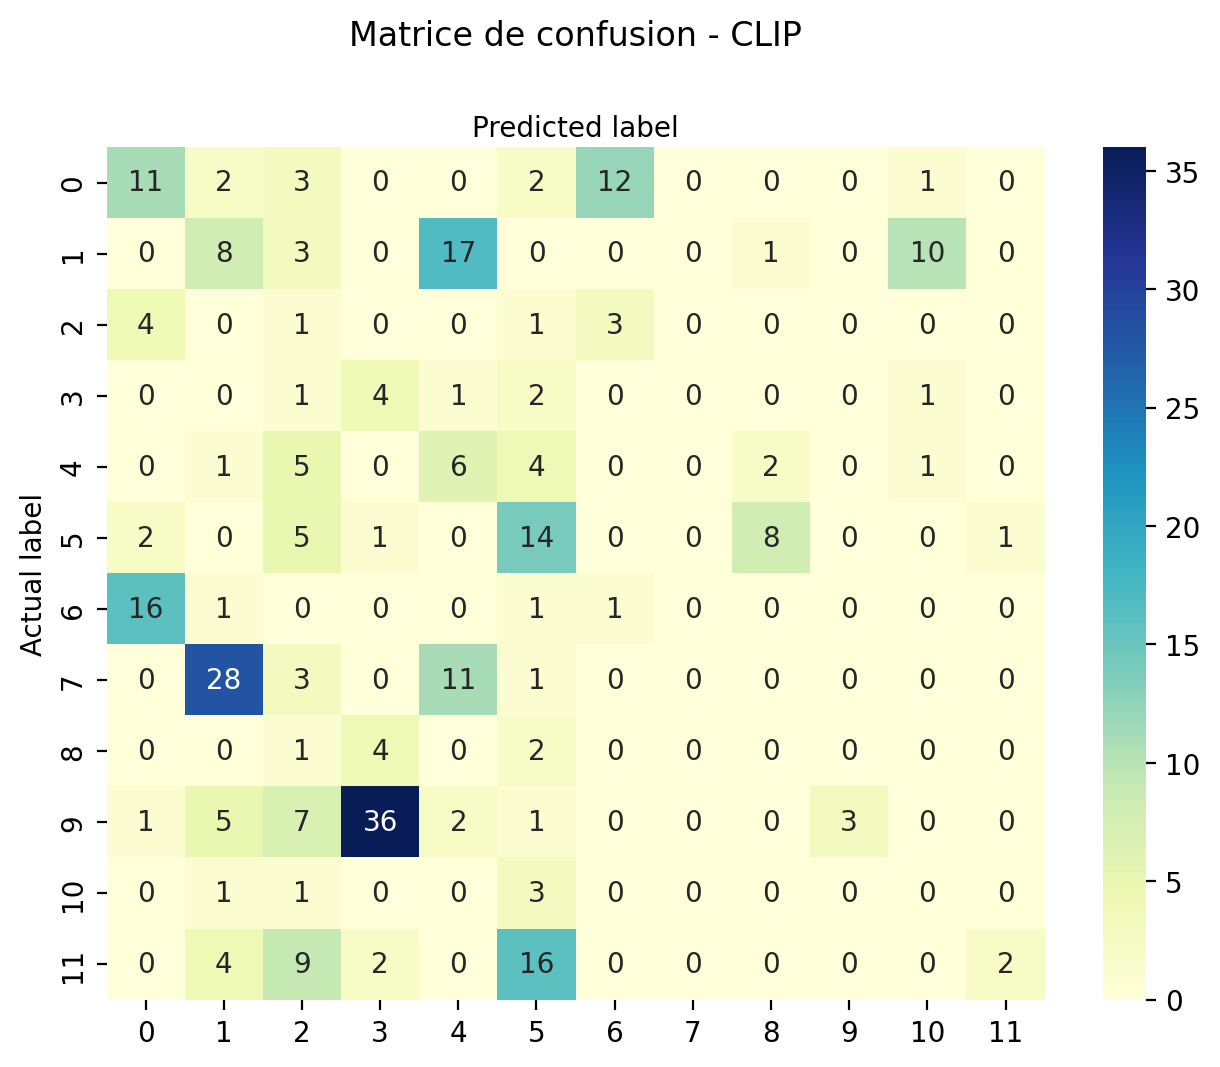

In [118]:
disg_cm = metrics.confusion_matrix(disg_top_labels[:,0], df['disg_num_cat'])
fix, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(ticks=tick_marks, labels=class_names)
plt.yticks(ticks=tick_marks, labels=class_names)
sns.heatmap(pd.DataFrame(disg_cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrice de confusion - CLIP', y =1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [96]:
print(metrics.classification_report(disg_top_labels[:,0], df['disg_num_cat']))

              precision    recall  f1-score   support

           0       0.32      0.35      0.34        31
           1       0.16      0.21      0.18        39
           2       0.03      0.11      0.04         9
           3       0.09      0.44      0.14         9
           4       0.16      0.32      0.21        19
           5       0.30      0.45      0.36        31
           6       0.06      0.05      0.06        19
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00         7
           9       1.00      0.05      0.10        55
          10       0.00      0.00      0.00         5
          11       0.67      0.06      0.11        33

    accuracy                           0.17       300
   macro avg       0.23      0.17      0.13       300
weighted avg       0.36      0.17      0.15       300



/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Performances prédictives KNN

In [146]:
# Get the data and model ready
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
model = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
X_train, X_test, y_train, y_test = train_test_split(embedding, df['disg_num_cat'], random_state=seed, test_size=0.3)
Z_train = StandardScaler().fit_transform(X_train)
Z_test = StandardScaler().fit_transform(X_test)

# Fit model, predict and print result
model.fit(Z_train,y_train)
y_pred = model.predict(Z_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       1.00      0.74      0.85        19
           2       0.43      0.60      0.50        10
           3       0.87      0.93      0.90        14
           4       0.64      0.75      0.69        12
           5       0.42      0.45      0.43        11
           6       0.67      0.80      0.73         5
           8       1.00      0.33      0.50         3
           9       0.00      0.00      0.00         1
          10       0.25      0.25      0.25         4

    accuracy                           0.69        90
   macro avg       0.62      0.57      0.57        90
weighted avg       0.72      0.69      0.69        90



/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

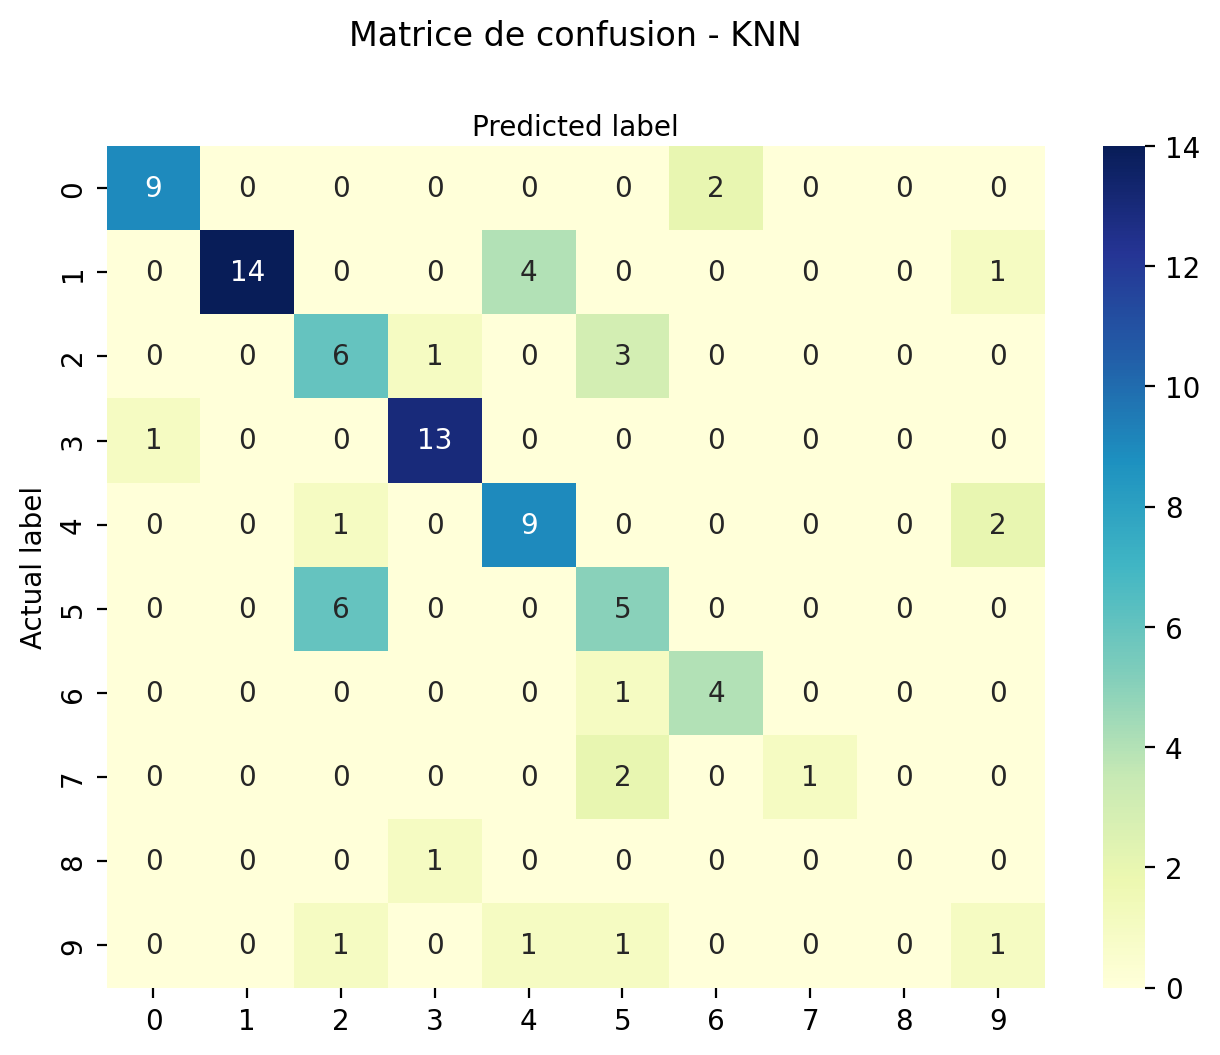

In [147]:
# disg_knn_cm = metrics.confusion_matrix(y_test,y_pred)
# fix, ax = plt.subplots()
# tick_marks = [0,1,2,3,4,5,6,8,9,10]
# class_names = ['food', 'animals', 'body products', 'innjuries_infections', 'death', 'hygiene', 'disgusting food', 'disgusting body products', 'disgusting injuries_infections', 'disgusting death']
# plt.xticks(ticks=tick_marks, labels=class_names)
# plt.yticks(ticks=tick_marks, labels=class_names)
# sns.heatmap(pd.DataFrame(disg_knn_cm), annot=True, cmap="YlGnBu", fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Matrice de confusion - KNN', y =1.1)
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.show()

disg_knn_cm = metrics.confusion_matrix(y_test,y_pred)
# class_names = ['food', 'animals', 'body_products', 'injuries_infections', 'death', 'hygiene']
fix, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(ticks=tick_marks, labels=class_names)
# plt.yticks(ticks=tick_marks, labels=class_names)
sns.heatmap(pd.DataFrame(disg_knn_cm), annot=True, cmap="YlGnBu")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrice de confusion - KNN', y =1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/Users/shwnmnl/opt/anaconda3/envs/ift6501/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


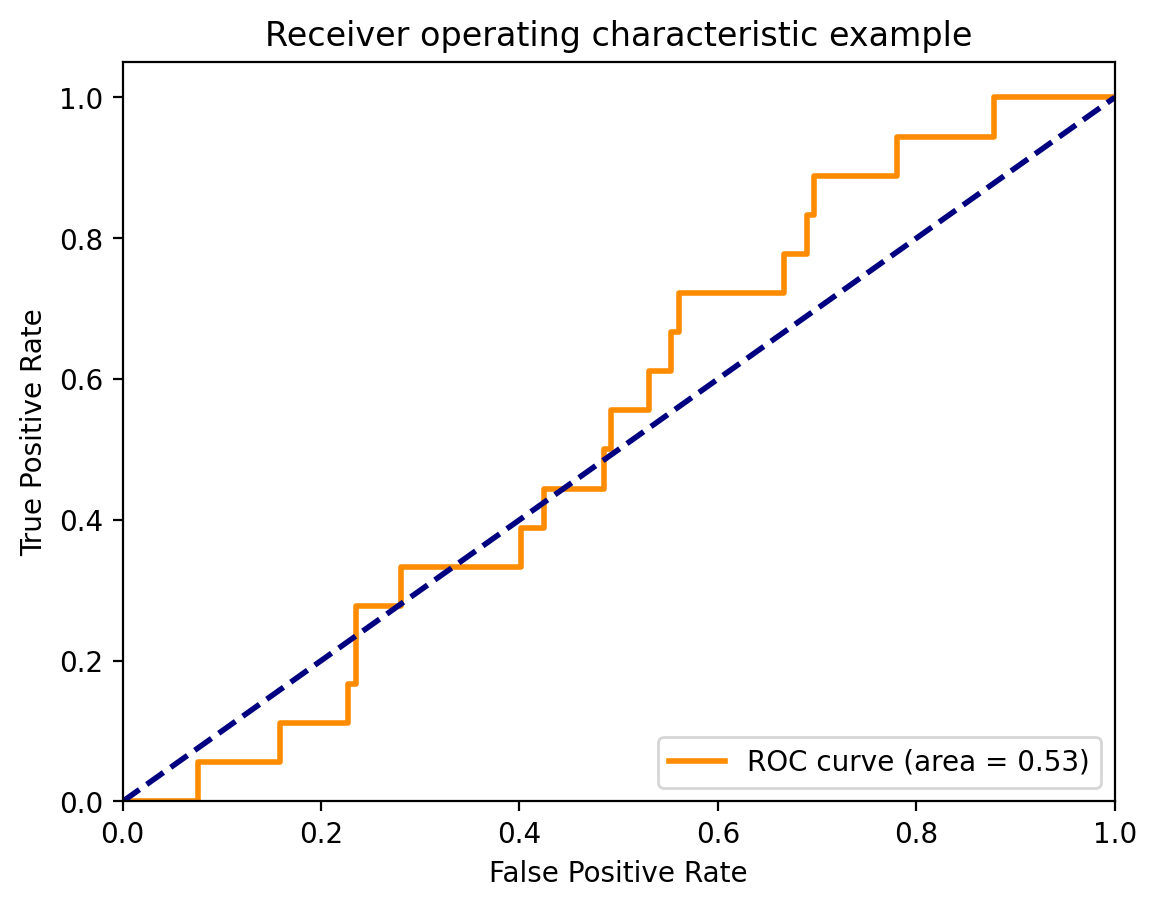

In [81]:
y = label_binarize(df['disg_num_cat'], classes=[0,1,2,3,4,5,6,7,8,9,10,11])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(embedding, y, random_state=0, test_size=0.5)

random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True, random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

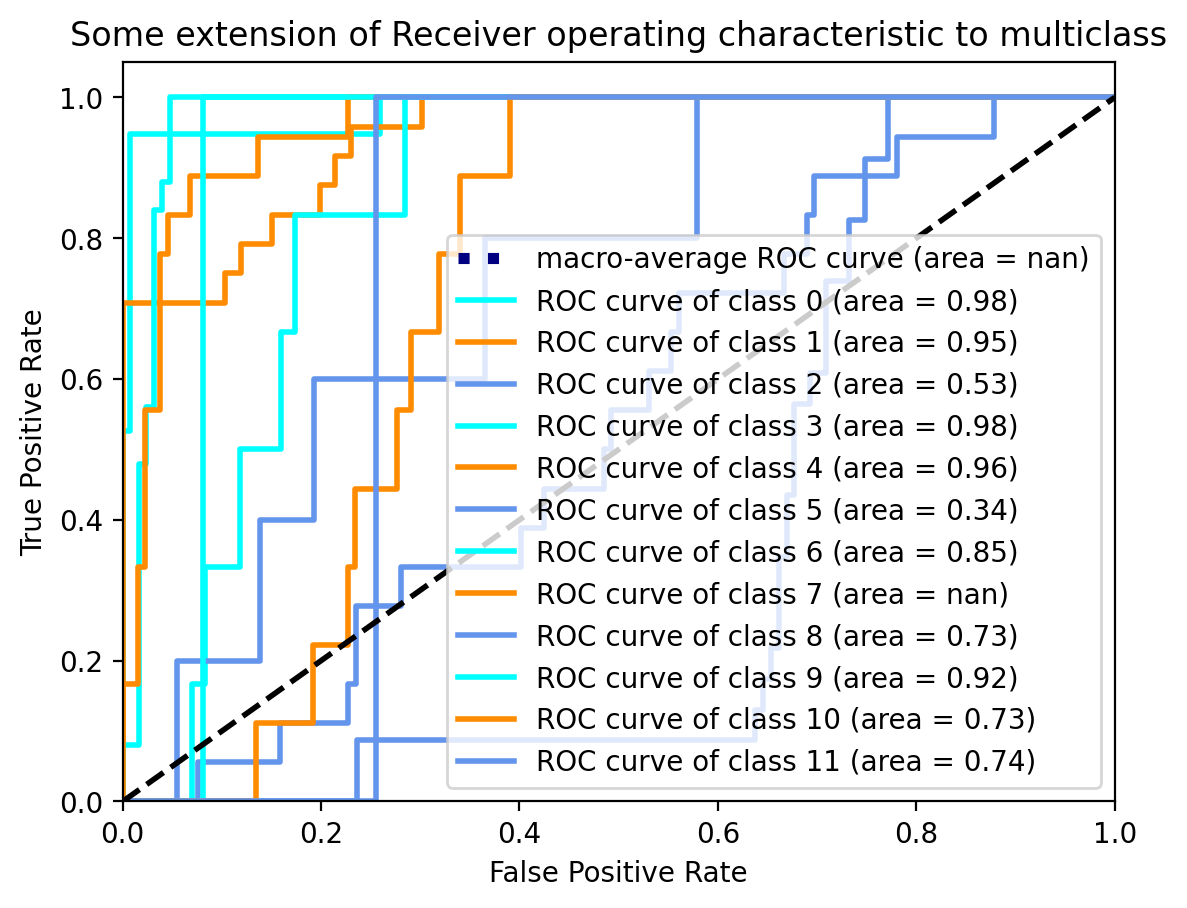

In [85]:
# Macro

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()
